<img src="https://docs.dask.org/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# dask.delayed - parallelize any code

What if you don't have an array or dataframe? Instead of having blocks where the function is applied to each block, you can decorate functions with `@delayed` and _have the functions themselves be lazy_. 

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask). 

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

/Users/nollde/tools/miniforge3/envs/dask-tutorial/lib/python3.14/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55506 instead
  warnings.warn(


## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [2]:
from time import sleep


def inc(x):
    sleep(1)
    return x + 1


def add(x, y):
    sleep(1)
    return x + y

Let's time the execution of this

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 75.1 ms, sys: 34.5 ms, total: 110 ms
Wall time: 3.01 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll make the `inc` and `add` functions lazy using the `dask.delayed` decorator. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [4]:
import dask


@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


@dask.delayed
def add(x, y):
    sleep(1)
    return x + y

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 429 μs, sys: 206 μs, total: 635 μs
Wall time: 605 μs


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 55.8 ms, sys: 24.7 ms, total: 80.5 ms
Wall time: 2.02 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [7]:
z

Delayed('add-a608e059-c712-413d-9c3b-4bfc79386ff6')

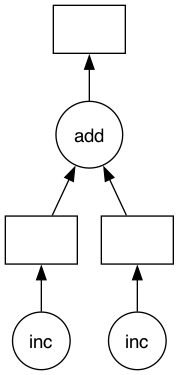

In [8]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [9]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [12]:
%%time
# Sequential code


def inc(x):
    sleep(1)
    return x + 1


results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
print("Total :", total)

Total : 44
CPU times: user 191 ms, sys: 91.3 ms, total: 282 ms
Wall time: 8.03 s


In [13]:
%%time

@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('add-3bd3f0f33d97bf6f2956c9e8868adbfd')
After computing : 44
CPU times: user 39 ms, sys: 17.1 ms, total: 56 ms
Wall time: 1.05 s


### Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [ ]:
client.close()